## **DenseNet-169 CNN Model K-fold**

### **1. Import the necessary libraries**


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Building DenseNet-169 Model**


In [3]:
def create_densenet169_model(learning_rate=0.001, dropout_rate=0.0, dense_units=128):
    # Load pre-trained DenseNet169 model without top layers
    base_model = DenseNet169(
        weights="imagenet", include_top=False, input_shape=(256, 256, 3)
    )

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **4. Train the Model**


In [4]:
# Define best parameters Best Parameters: {'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.001}
learning_rate = 0.001
dropout_rate = 0.5
dense_units = 256
img_size = 256
batch_size = 12

# Store all models and histories
models = {}

# Define the paths
data_dir = f"../DATASETS/kfold_dataset_{img_size}"  # Directory containing train, val, and test directories

# Iterate over the splits
for i in range(5):
    print(f"Fold {i + 1}")
    train_dir = data_dir + f"/train_fold_{i}"
    val_dir = data_dir + f"/val_fold_{i}"

    # ImageDataGenerator for data augmentation and normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # Create model with current parameters
    model = create_densenet169_model(
        learning_rate=learning_rate, dropout_rate=dropout_rate, dense_units=dense_units
    )

    # # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        # callbacks=[early_stopping],
    )

    # Retrieve validation accuracy from history
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    models[i] = {
        "model": model,
        "history": history.history,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
    }

# Save the best model
highest_accuracy = 0
best_model = None
for key, value in models.items():
    if value["val_accuracy"] >= highest_accuracy:
        if value["val_accuracy"] == highest_accuracy:
            if value["val_loss"] < val_loss:
                highest_accuracy = value["val_accuracy"]
                best_model = value["model"]
        else:
            highest_accuracy = value["val_accuracy"]
            best_model = value["model"]

# Save the best model
print(f"Highest Accuracy: {highest_accuracy}")
best_model.save("DenseNet169_model_kfold.h5")

Fold 1
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/25
32/32 [==============================] - 18s 200ms/step - loss: 1.3315 - accuracy: 0.4453 - val_loss: 0.6564 - val_accuracy: 0.7083
Epoch 2/25
32/32 [==============================] - 4s 133ms/step - loss: 0.8358 - accuracy: 0.6510 - val_loss: 0.6574 - val_accuracy: 0.7292
Epoch 3/25
32/32 [==============================] - 4s 126ms/step - loss: 0.6268 - accuracy: 0.7448 - val_loss: 0.5370 - val_accuracy: 0.7917
Epoch 4/25
32/32 [==============================] - 4s 127ms/step - loss: 0.6134 - accuracy: 0.7656 - val_loss: 0.4769 - val_accuracy: 0.8438
Epoch 5/25
32/32 [==============================] - 4s 126ms/step - loss: 0.5581 - accuracy: 0.7786 - val_loss: 0.4608 - val_accuracy: 0.8125
Epoch 6/25
32/32 [==============================] - 4s 128ms/step - loss: 0.5853 - accuracy: 0.7760 - val_loss: 0.4494 - val_accuracy: 0.8333
Epoch 7/25
32/32 [==============================] - 4s 135m

### **5. Evaluate and Visualize Results**


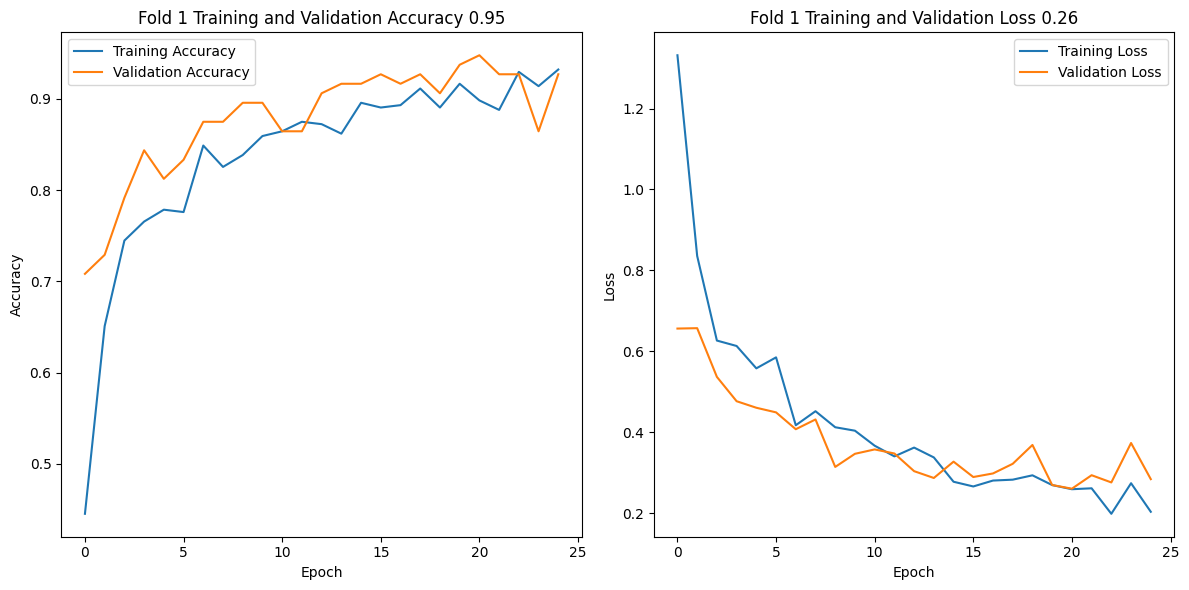

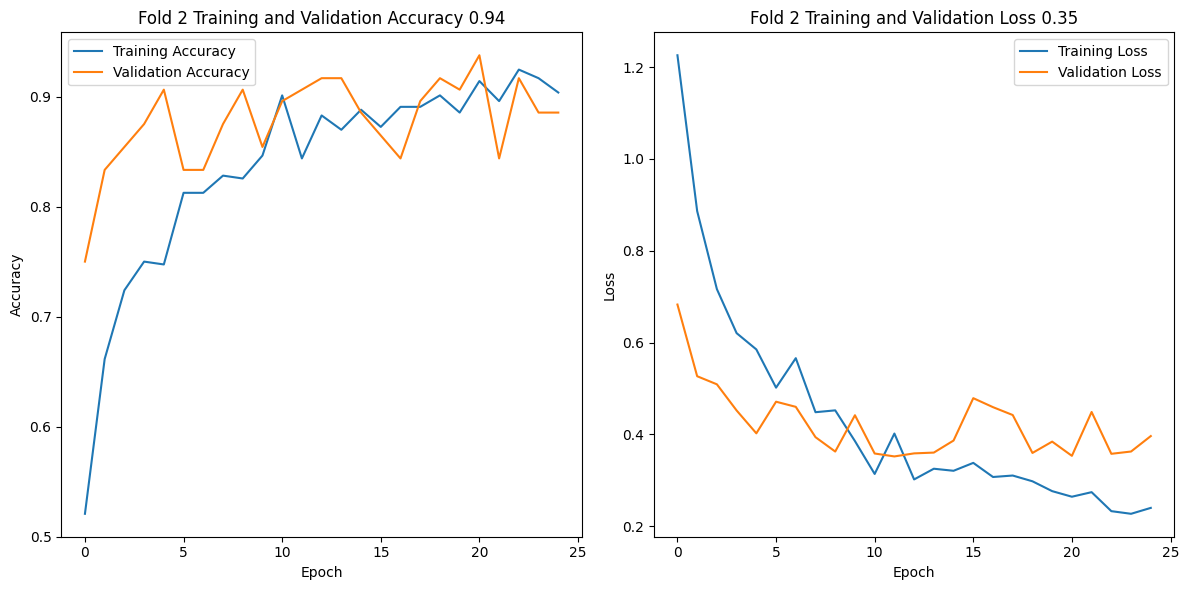

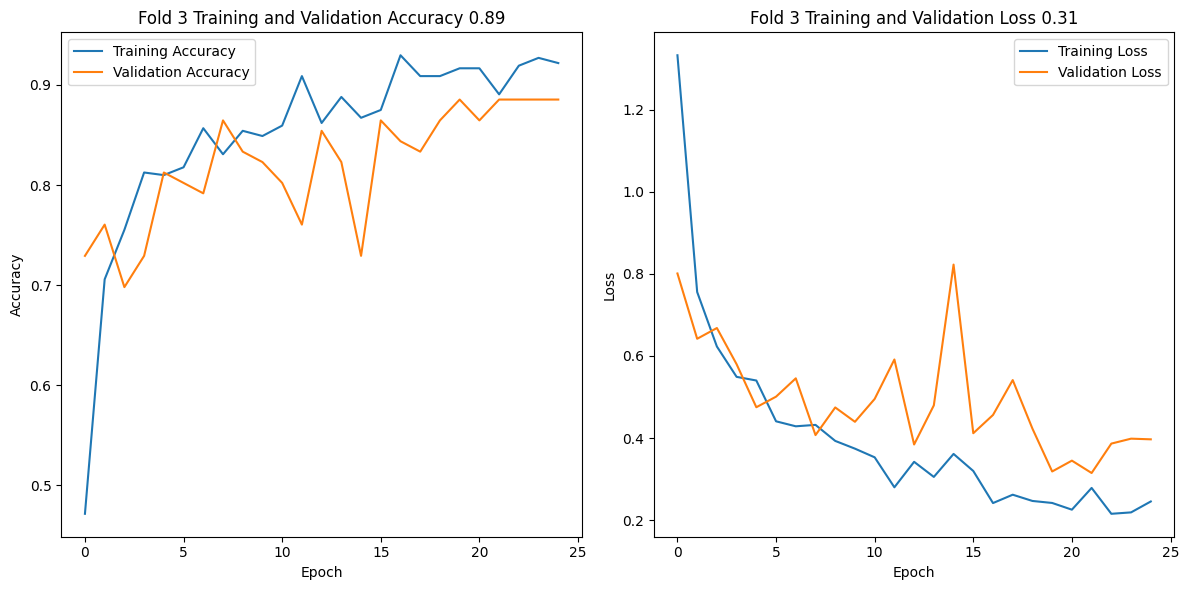

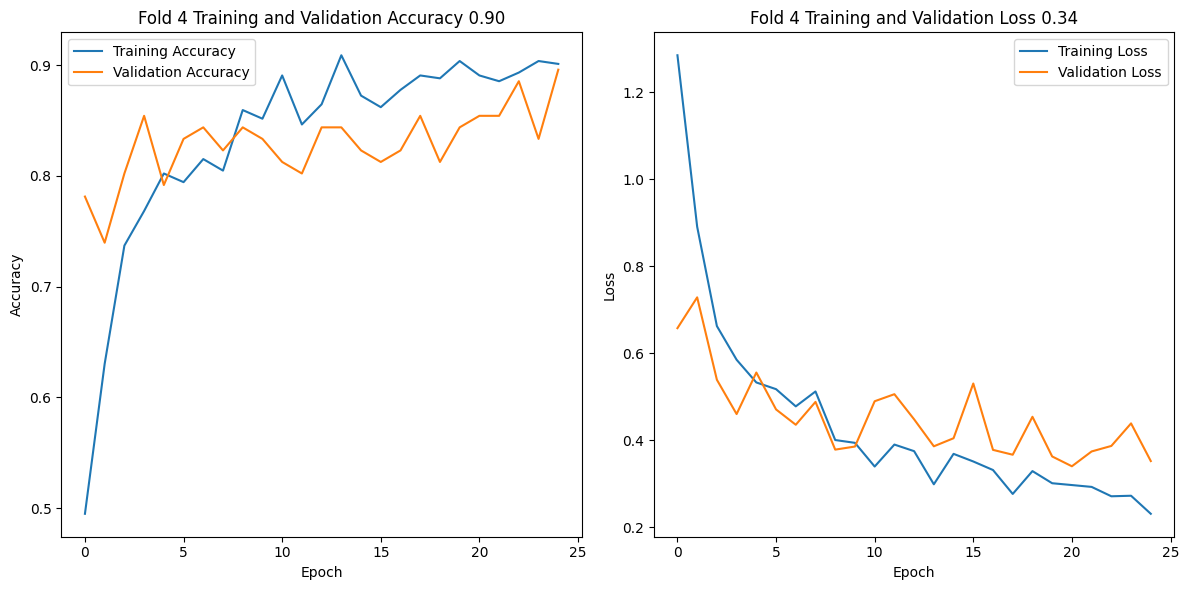

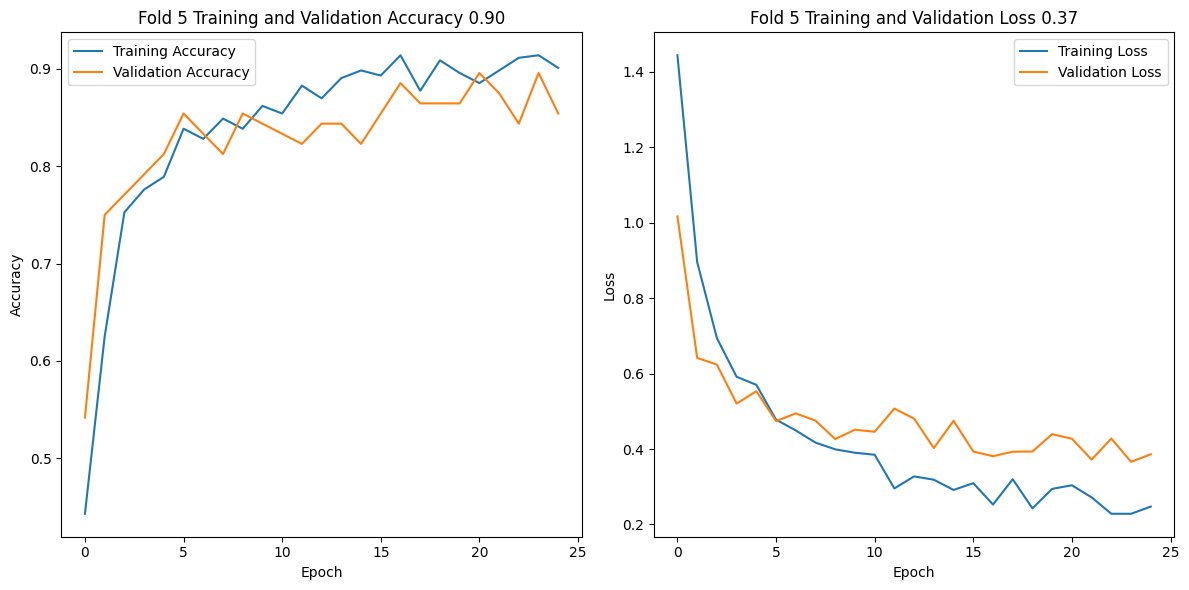

In [5]:
# Plot all training history
for key, value in models.items():
    accuracy = value['val_accuracy']
    loss = value['val_loss']
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(value["history"]["accuracy"], label="Training Accuracy")
    plt.plot(value["history"]["val_accuracy"], label="Validation Accuracy")
    plt.title(f'Fold { key + 1 } Training and Validation Accuracy {accuracy:.2f}')
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(value["history"]["loss"], label="Training Loss")
    plt.plot(value["history"]["val_loss"], label="Validation Loss")
    plt.title(f"Fold {key + 1} Training and Validation Loss {loss:.2f}")
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

Fold 1 - Accuracy: 0.9479 - Loss: 0.2608
Fold 1
Found 96 images belonging to 4 classes.
8/8 [==============================] - 3s 73ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.83      0.91        24
  meningioma       0.84      0.88      0.86        24
     notumor       0.96      1.00      0.98        24
   pituitary       0.92      1.00      0.96        24

    accuracy                           0.93        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.93      0.93      0.93        96



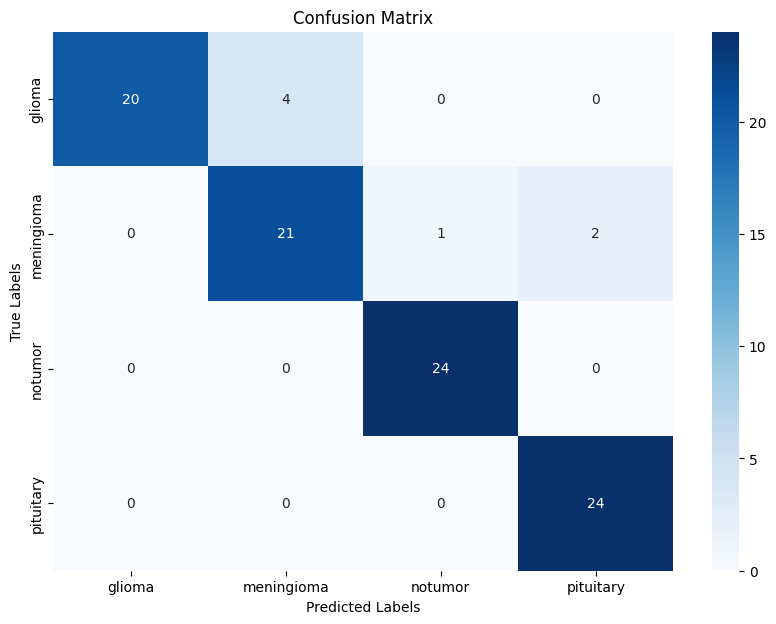

Fold 2 - Accuracy: 0.9375 - Loss: 0.3521
Fold 2
Found 96 images belonging to 4 classes.
8/8 [==============================] - 3s 69ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.92      0.92        24
  meningioma       0.94      0.71      0.81        24
     notumor       0.88      0.96      0.92        24
   pituitary       0.82      0.96      0.88        24

    accuracy                           0.89        96
   macro avg       0.89      0.89      0.88        96
weighted avg       0.89      0.89      0.88        96



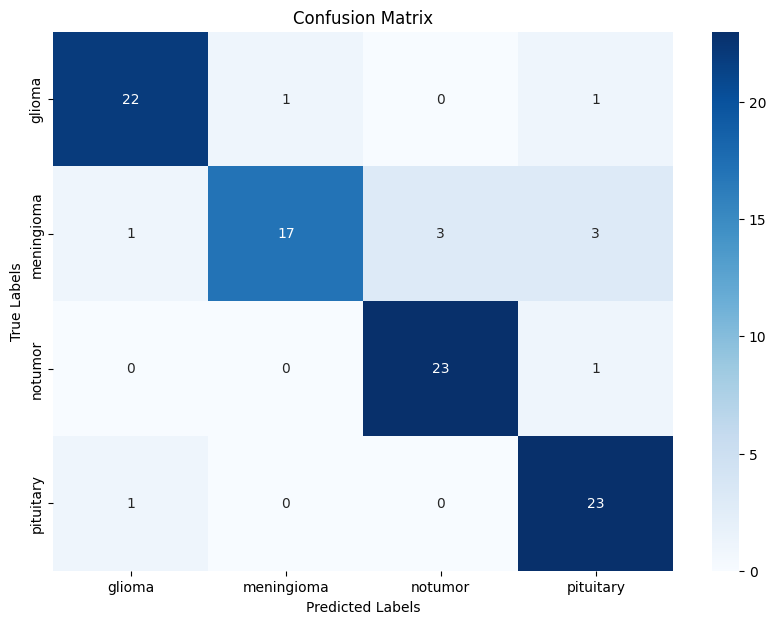

Fold 3 - Accuracy: 0.8854 - Loss: 0.3148
Fold 3
Found 96 images belonging to 4 classes.
8/8 [==============================] - 3s 72ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.96      0.94        24
  meningioma       0.94      0.67      0.78        24
     notumor       0.88      0.92      0.90        24
   pituitary       0.83      1.00      0.91        24

    accuracy                           0.89        96
   macro avg       0.89      0.89      0.88        96
weighted avg       0.89      0.89      0.88        96



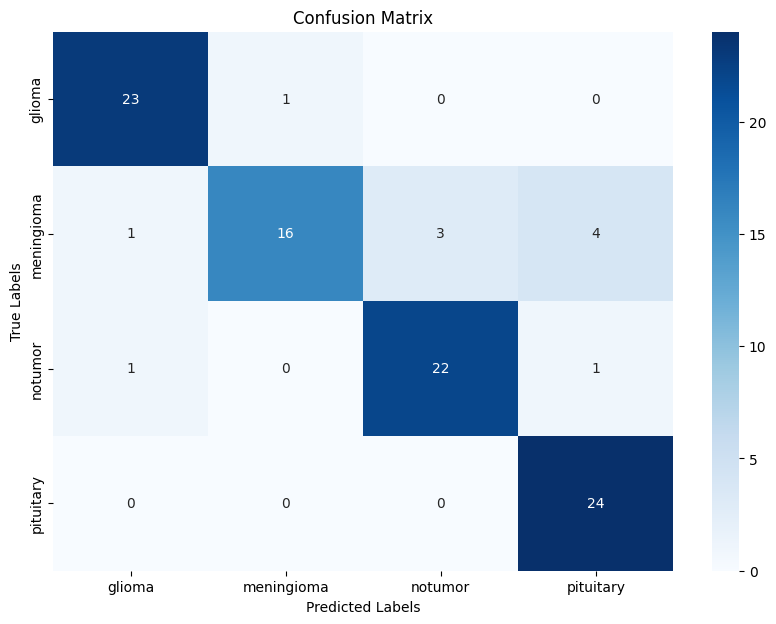

Fold 4 - Accuracy: 0.8958 - Loss: 0.3400
Fold 4
Found 96 images belonging to 4 classes.
8/8 [==============================] - 3s 68ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.88      0.93        24
  meningioma       0.95      0.75      0.84        24
     notumor       0.88      0.96      0.92        24
   pituitary       0.80      1.00      0.89        24

    accuracy                           0.90        96
   macro avg       0.91      0.90      0.89        96
weighted avg       0.91      0.90      0.89        96



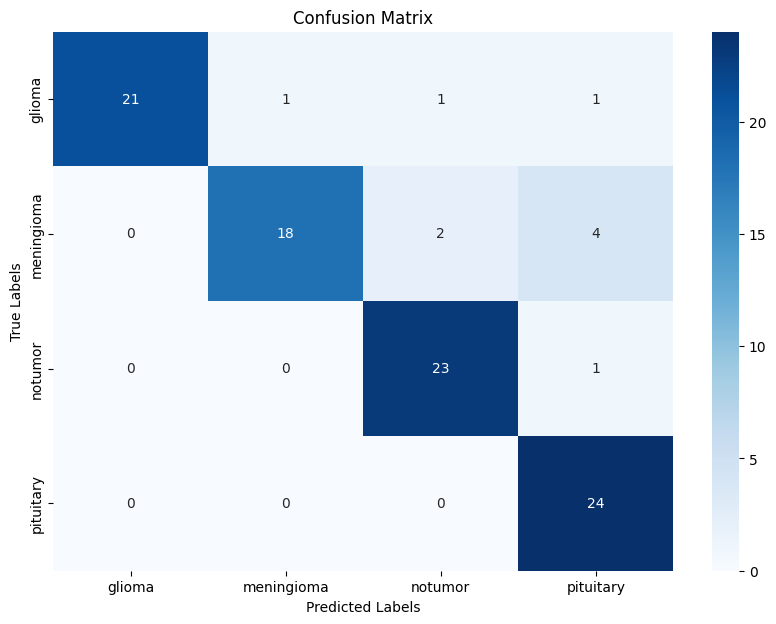

Fold 5 - Accuracy: 0.8958 - Loss: 0.3659
Fold 5
Found 96 images belonging to 4 classes.
8/8 [==============================] - 3s 58ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.78      0.88      0.82        24
  meningioma       0.88      0.58      0.70        24
     notumor       0.88      0.96      0.92        24
   pituitary       0.89      1.00      0.94        24

    accuracy                           0.85        96
   macro avg       0.86      0.85      0.85        96
weighted avg       0.86      0.85      0.85        96



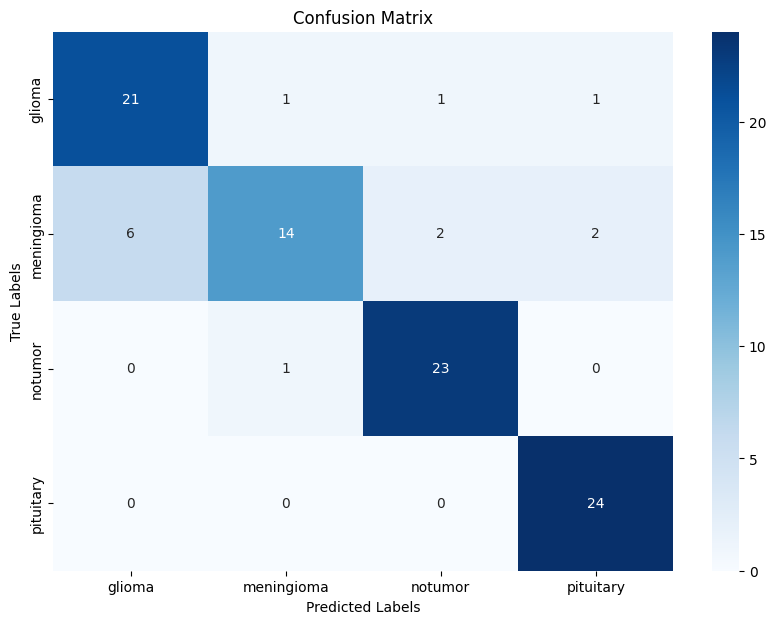

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load the saved model
image_size = 256
for key, value in models.items():
    accuracy = value['val_accuracy']
    loss = value['val_loss']
    model = value["model"]
    print(f"Fold {key + 1} - Accuracy: {accuracy:.4f} - Loss: {loss:.4f}")
    print(f"Fold {key + 1}")

    # Define the paths
    val_dir = data_dir + f"/val_fold_{key}"

    # ImageDataGenerator for normalization
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Data generator for test set
    test_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(
            image_size,
            image_size,
        ),  # Adjust if your model was trained with a different target size
        batch_size=12,  # Adjust based on your batch size during training
        class_mode="categorical",
        shuffle=False,
    )
    categories = ["glioma", "meningioma", "notumor", "pituitary"]

    # Predict the labels for the test set
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Compute the classification report
    report = classification_report(y_true, y_pred_classes, target_names=categories)
    print("Classification Report:\n")
    print(report)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=categories,
        yticklabels=categories,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()